In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Links url
exportacoes2024 = 'https://balanca.economia.gov.br/balanca/bd/comexstat-bd/mun/EXP_2024_MUN.csv'
mun = 'https://balanca.economia.gov.br/balanca/bd/tabelas/UF_MUN.csv'
sh4 = 'https://balanca.economia.gov.br/balanca/bd/tabelas/NCM_SH.csv'
pais = 'https://balanca.economia.gov.br/balanca/bd/tabelas/PAIS.csv'

# Carregar os arquivos CSV
df = pd.read_csv(exportacoes2024, sep=";", encoding="latin1")
df_mun = pd.read_csv(mun, sep=";", encoding="latin1")
df_sh4 = pd.read_csv(sh4, sep=";", encoding="latin1")
df_pais = pd.read_csv(pais, sep=";", encoding="latin1")

In [65]:
#vendo se tem campo vazio
df.isna().sum()
df_mun.isna().sum()
df_sh4.isna().sum()

#vendo se tem campo duplicado
df.loc[df.duplicated()]
df_mun.loc[df_mun.duplicated()]
df_sh4.loc[df_sh4.duplicated()]

# Filtrar dados para o estado de São Paulo (SP)
df = df[df["SG_UF_MUN"] == "SP"]

# Calcular valor agregado (VL_FOB / KG_LIQUIDO)
df["VALOR_AGREGADO"] = df["VL_FOB"] / df["KG_LIQUIDO"]

# Tratar casos onde KG_LIQUIDO é zero para evitar divisão por zero
df = df[df["KG_LIQUIDO"] > 0]

# Renomear coluna para compatibilidade com a base de municípios
df_mun = df_mun.rename(columns={"CO_MUN_GEO": "CO_MUN"})

# Mesclar com os nomes dos municípios
df = df.merge(df_mun, on=["CO_MUN"], how="left")

# Remover a coluna 'SG_UF' pois existe a 'SG_UF_MUN':
df = df.drop('SG_UF', axis=1)

# Renomear coluna para compatibilidade com a base de produtos
df_sh4 = df_sh4.rename(columns={"CO_SH4": "SH4", "NO_SH4_POR": "PRODUTO"})

# Mesclar com os nomes dos produtos
df = df.merge(df_sh4, on=["SH4"], how="left")

# Remover as colunas que não sejam o SH4 e o Produto:
df = df.drop( ['CO_SH6', 'NO_SH6_POR', 'NO_SH6_ESP', 'NO_SH6_ING','NO_SH4_ESP', 'NO_SH4_ING', 'CO_SH2', 'NO_SH2_POR', 'NO_SH2_ESP', 'NO_SH2_ING', 'CO_NCM_SECROM', 'NO_SEC_POR', 'NO_SEC_ESP','NO_SEC_ING'], axis=1)

<ipython-input-65-52149ece56fe>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["VALOR_AGREGADO"] = df["VL_FOB"] / df["KG_LIQUIDO"]


In [66]:
# Filtra uma cidade específica [A SER ALTERADO]
# Nome da cidade deve ser da coluna DEF_MUN do csv UF_MUN
cidade = "SAO JOSE DOS CAMPOS"
# Capitaliza o nome por segurança, como todos os NO_MUN são em letra maíscula
cidade = cidade.upper()

# Pega o nome 'normal' de uma cidade usando o código por df_mun (ex: "SAO JOSE DOS CAMPOS" vira "São José dos Campos"), utilizado para o nome do gráfico
cidade_min = df_mun.loc[df_mun["NO_MUN"] == cidade, "NO_MUN_MIN"]
cidade_min = cidade_min.iloc[0]

# Filtra pela cidade escolhida
df = df[df["NO_MUN"] == cidade]

SAO JOSE DOS CAMPOS
São José dos Campos
         CO_ANO  CO_MES   SH4  CO_PAIS SG_UF_MUN   CO_MUN  KG_LIQUIDO  VL_FOB  \
38         2024       7  4016      741        SP  3449904           1    1116   
39         2024       7  4016      741        SP  3449904           1    1116   
40         2024       7  4016      741        SP  3449904           1    1116   
41         2024       7  4016      741        SP  3449904           1    1116   
42         2024       7  4016      741        SP  3449904           1    1116   
...         ...     ...   ...      ...       ...      ...         ...     ...   
3445815    2024       5  1302      386        SP  3449904        4000   54000   
3445816    2024       5  1302      386        SP  3449904        4000   54000   
3445817    2024       5  1302      386        SP  3449904        4000   54000   
3445818    2024       5  1302      386        SP  3449904        4000   54000   
3445819    2024       5  1302      386        SP  3449904        4000

In [67]:
# Extraindo agrupamento a soma da coluna Valor FOB e suas respectivas cargas
cargas_valor_fob = df.groupby(['SG_UF_MUN','SH4','PRODUTO'])['VL_FOB'].sum().reset_index()

# Ordenando pela soma do valor FOB de forma decrescente e pegando os 10 primeiros
top10_cargas_valor_fob = cargas_valor_fob.sort_values(by='VL_FOB', ascending=False).head(10).reset_index(drop=True)

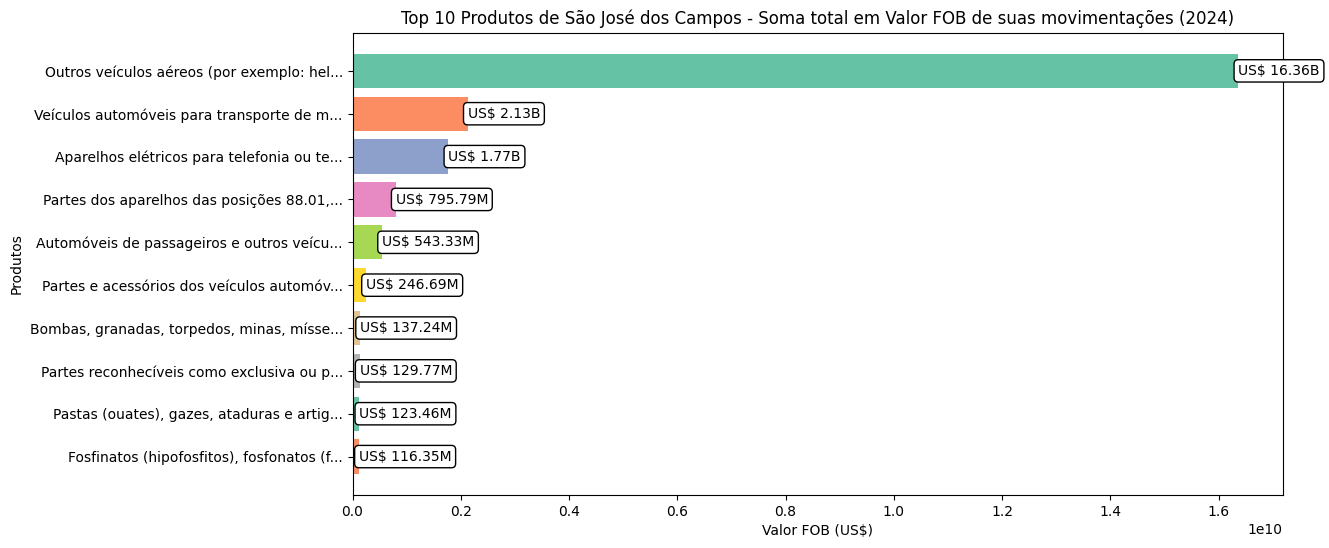

In [68]:
# --- Diminuindo o texto dos produtos em 40 caracteres ---
top10_cargas_valor_fob['PRODUTO_TRUNCADO'] = top10_cargas_valor_fob['PRODUTO'].apply(lambda x: x[:40] + '...' if len(x) > 20 else x)

# --- Gráfico dos 10 produtos com maior valor fob somado ---
# Usando uma paleta de cores do seaborn (pode ser qualquer uma das paletas, como 'Set1', 'tab10', etc.)
paleta_de_cores = sns.color_palette("Set2", n_colors=len(top10_cargas_valor_fob))

# Criar gráfico de barras com cores variadas
plt.figure(figsize=(12, 6))
bars_produtos = plt.barh(top10_cargas_valor_fob['PRODUTO_TRUNCADO'], top10_cargas_valor_fob['VL_FOB'], color=paleta_de_cores)

 # Adicionar uma caixa de texto com o valor us no meio de cada barra
for bar in bars_produtos:
    width = bar.get_width()  # O valor da barra no eixo X
    y_position = bar.get_y() + bar.get_height() / 2  # A posição no meio da barra no eixo Y

    # Verificar se o valor é maior que 1 milhão (1e6) ou 1 bilhão (1e9)
    if width >= 1e9:
        # Exibir em bilhões (B)
        label = f'US$ {width / 1e9:.2f}B'
    elif width >= 1e6:
        # Exibir em milhões (M)
        label = f'US$ {width / 1e6:.2f}M'
    else:
        # Exibir o valor original em reais, se menor que 1 milhão
        label = f'US$ {width:.2f}'

    # Adicionar o texto no gráfico
    plt.text(width, y_position, label, va='center', ha='left', color='black', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

  # Adicionar rótulos e título
plt.xlabel("Valor FOB (US$)")
plt.ylabel("Produtos")
plt.title("Top 10 Produtos de " + cidade_min + " - Soma total em Valor FOB de suas movimentações (2024)")

# Inverter a ordem do eixo Y para mostrar o maior valor no topo
plt.gca().invert_yaxis()